# Simple linear regression - Metropolis

# _Josep Fortiana_   $\hskip3cm$  2023-05-08

***
###### LaTeX macros
$ \def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\Var{\operatorname{Var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\cauchydist{\operatorname{Cauchy}}$
$\def\dexpdist{\operatorname{DExp}}$
$\def\expdist{\operatorname{Exp}}$
$\def\fdist{\operatorname{F}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\halfcauchydist{\operatorname{Cauchy}^{+}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\invgammadist}{IG}$
$\def\laplacedist{\operatorname{Laplace}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\normaldist{\operatorname{N}}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\tdist{\operatorname{t}}$
$\def\unifdist{\operatorname{Unif}}$
$\def\xbar{\kern1.3pt\overline{\kern-1.3pt x}}$
$\def\Xbar{\kern1.3pt\overline{\kern-1.3pt X}}$
$\def\yhat{\kern1.3pt\hat{\kern-1.3pt y}}$
$\def\betahat{\kern1.3pt\hat{\kern-1.3pt \beta}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
$\def\eqdef{\stackrel{\text{def}}{\mskip3mu=\mskip3mu}}$
***

# Exercise 2

Prepare and run a Metropolis-Hastings MCMC simulation for a simple least squares regression model.

This exercise closely follows the explanatory text and R scripts in [Florian Hartig's blog.](https://theoreticalecology.wordpress.com/2010/09/17/metropolis-hastings-mcmc-in-r/)

It is advisable to work in parallel, performing computations here and reading the blog explanations.

Warning: I switched labels `a` and `b` for intercept and slope from Hartig's notation.

## Creating test data

In [1]:
set.seed(24025)
trueA<-0  # R notation for abline: b is the slope
trueB<-5
trueSd<-10
sampleSize<-31
# create independent x-values 
x<-(-(sampleSize-1)/2):((sampleSize-1)/2)
# create dependent values according to a + b*x + N(0,sd)
y<-trueA+trueB*x+rnorm(n=sampleSize,mean=0,sd=trueSd)

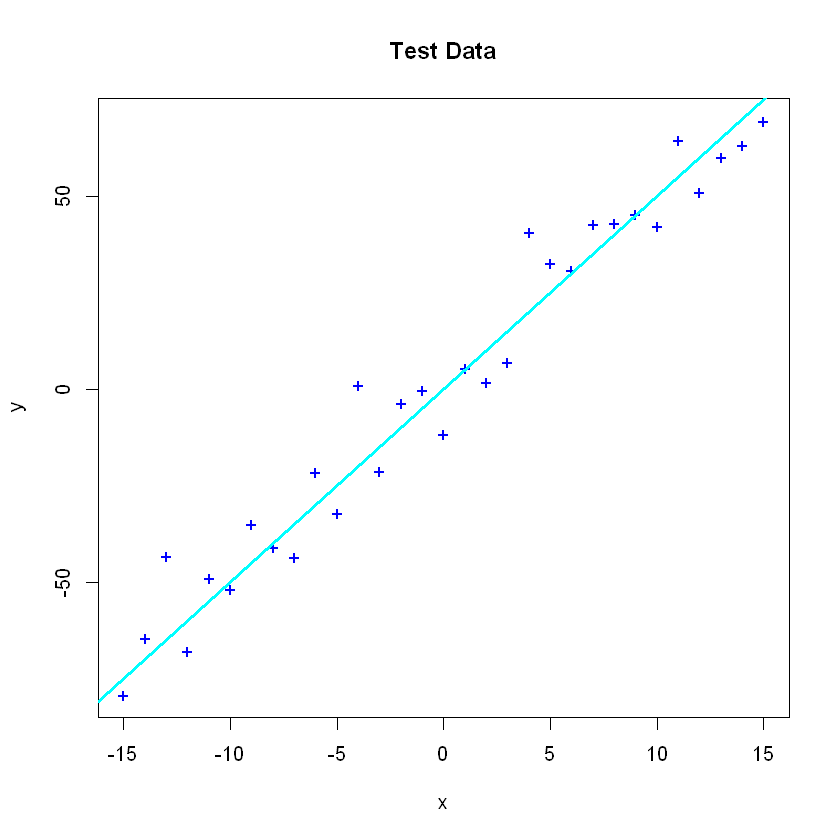

In [2]:
options(repr.plot.width=7,repr.plot.height=7)
plot(x,y,pch='+',col="blue",main="Test Data")
abline(trueA,trueB,lwd=2.5,col="cyan")

## Fit a classical linear model

Assuming the common standard deviation is a known constant.

In [3]:
lm.1<-lm(y~x)
summary(lm.1)
a.hat<-as.numeric(lm.1$coefficients[1])
b.hat<-as.numeric(lm.1$coefficients[2])


Call:
lm(formula = y ~ x)

Residuals:
    Min      1Q  Median      3Q     Max 
-12.743  -7.732  -0.552   5.520  20.432 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.2031     1.6579   0.726    0.474    
x             4.7915     0.1854  25.851   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 9.231 on 29 degrees of freedom
Multiple R-squared:  0.9584,	Adjusted R-squared:  0.957 
F-statistic: 668.3 on 1 and 29 DF,  p-value: < 2.2e-16


In [4]:
lm.1.anova<-anova(lm.1)
lm.1.anova
# str(lm.1.anova)
sigma2.hat<-lm.1.anova$Sum[2]/lm.1.anova$Df[2]
sigma.hat<-sqrt(sigma2.hat)
sprintf("Estimated intercept = %f",round(a.hat,3))
sprintf("Estimated slope = %f",round(b.hat,3))
sprintf("Estimated std. deviation = %f",round(sigma.hat,3))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
x,1,56938.147,56938.14661,668.2632,1.416233e-21
Residuals,29,2470.892,85.20318,NA,NA


[1] "Estimated intercept = 1.203000"

[1] "Estimated slope = 4.792000"

[1] "Estimated std. deviation = 9.231000"

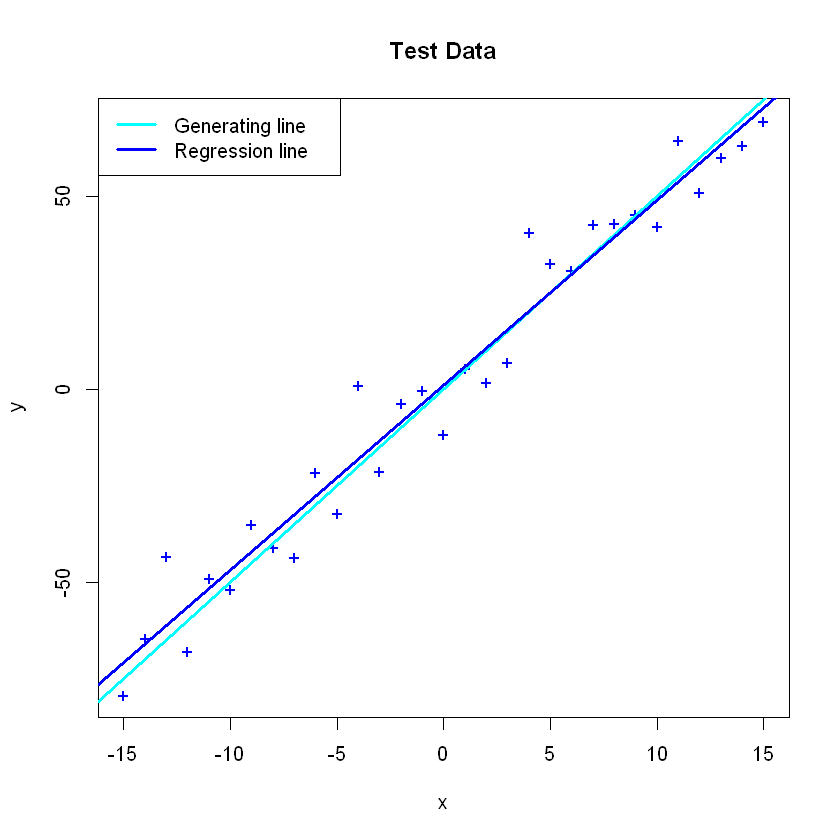

In [5]:
options(repr.plot.width=7,repr.plot.height=7)
plot(x,y,pch='+',col="blue",main="Test Data")
abline(trueA,trueB,lwd=2.5,col="cyan")
abline(lm.1,lwd=2.5,col="blue")
legend("topleft",c("Generating line","Regression line"), lwd=2.5,col=c("cyan","blue"))

## Log-Likelihood

We assume a normal linear model, that is, each observation $y_i\sim\operatorname{N}(a+b\cdot x_i,\sigma^2)$   
and they are uncorrelated. 

Parameters are $a$ (intercept), $b$ (slope) and the common standard deviation $\sigma$.

The sample likelihood function is the product of the $n$ individual likelihoods. 

The sample log-likelihood is the sum of the $n$ individual log-likelihoods.

In [6]:
log.likelihood <- function(param){
    a<-param[1]
    b<-param[2]
    sd<-param[3]
    pred<-a+b*x
    singleloglikelihoods = dnorm(y,mean=pred,sd=sd,log=TRUE)
    sumll<-sum(singleloglikelihoods)
    return(sumll)   
    }

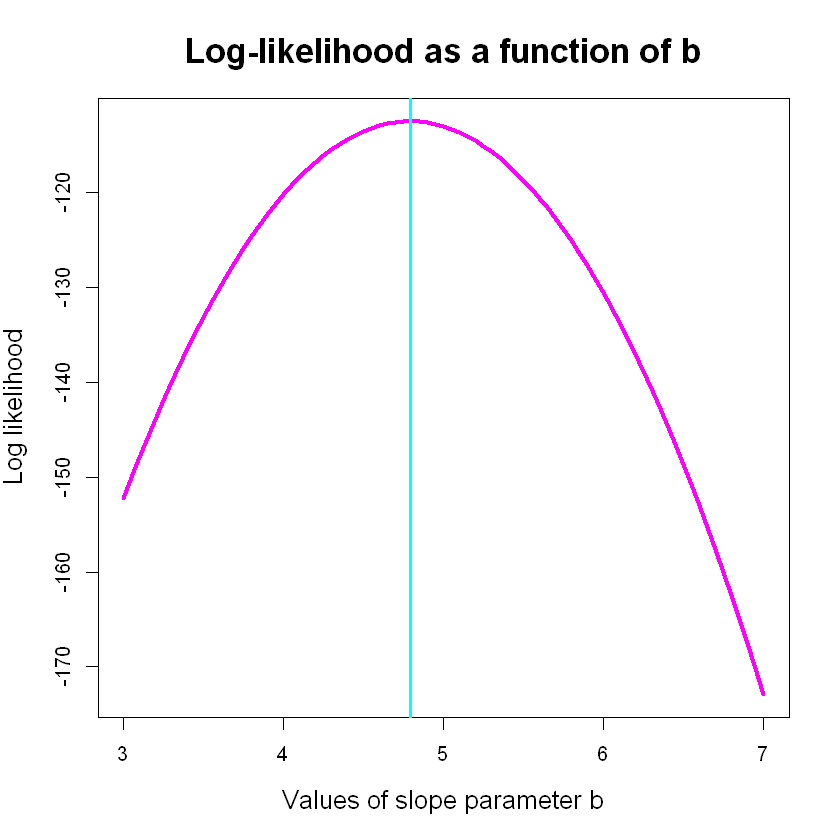

In [7]:
# Example: plot the loglikelihood profile of the slope b
slopevalues<-function(b){return(log.likelihood(c(trueA,b,trueSd)))}
slopelikelihoods<-lapply(seq(3,7,by=0.05),slopevalues)
options(repr.plot.width=7,repr.plot.height=7)
plot(seq(3,7,by=0.05),slopelikelihoods,type="l",lwd=3.5,col="magenta",xlab="Values of slope parameter b", 
     ylab="Log likelihood",main="Log-likelihood as a function of b",cex.main=1.7,cex.lab=1.3)
abline(v=b.hat,col="cyan",lwd=2.5) # Max likelihood estimator of b

## Prior

- Normal prior for the intercept, with mean=0 and sd=5.
- Uniform(0,10) for the slope.
- Uniform(0,30) for the sd parameter.

We take these priors as independent (in particular this is not a conjugate prior, except for the intercept).

Thus, the global prior is the product of these pdf's. Taking logarithms, we have the sum of logs of   
prior pdfs, to be added to the log-likelihood to give the log-joint pdf, proportional to the log-posterior.

In [8]:
log.prior <- function(param){
    a<-param[1]
    b<-param[2]
    sd<-param[3]
    aprior<-dnorm(a,mean=0,sd=5,log=TRUE)
    bprior<-dunif(b,min=0,max=10,log=TRUE)
    sdprior<-dunif(sd, min=0, max=30, log = TRUE)
    return(aprior+bprior+sdprior)
    }

## Unnormalized log-posterior

In [9]:
log.posterior <- function(param){
    return (log.likelihood(param)+log.prior(param))
    }

## Proposal function for the Metropolis algorithm

A normal pdf for each of the three parameters.

Their standard deviations should be decided by trial and error.

In [10]:
proposalfunction <- function(param){
    return(rnorm(3,mean=param, sd=c(0.5,0.1,0.3)))
    }

## Metropolis chain generation

In [11]:
metropolis_MCMC <- function(startvalue, iterations){
    chain<-array(dim = c(iterations+1,3))      # Allocate an array to store three chains, for (a,b,sigma)
    chain[1,]<-startvalue
    for (i in 1:iterations){
        proposal<-proposalfunction(chain[i,])
        prob<-exp(log.posterior(proposal) - log.posterior(chain[i,]))
        if (runif(1)<prob)
            chain[i+1,]<-proposal
        else
            chain[i+1,]<-chain[i,]
        }
    return(chain)
    }

## Run simulation 

- Decide chain length and `burnIn`

- Run simulation and discard first `burnIn` values

- Compute the acceptance rate

In [12]:
ChainLength<-4000
startvalue<-c(0,4,10)
chain<-metropolis_MCMC(startvalue,ChainLength)
# 
burnIn<-500
# Proportion of accepted transitions = non-duplicated chain values
acceptance<-1-mean(duplicated(chain[-(1:burnIn),])) 
round(acceptance,3)

[1] 0.764

## Posterior histograms

With superimposed cyan vertical lines indicating "Gen" values (i.e., values originally used for generating the sample), and bluen vertical lines indicating estimated values, the LS=ML estimates obtained from the classical linear model adjustment.

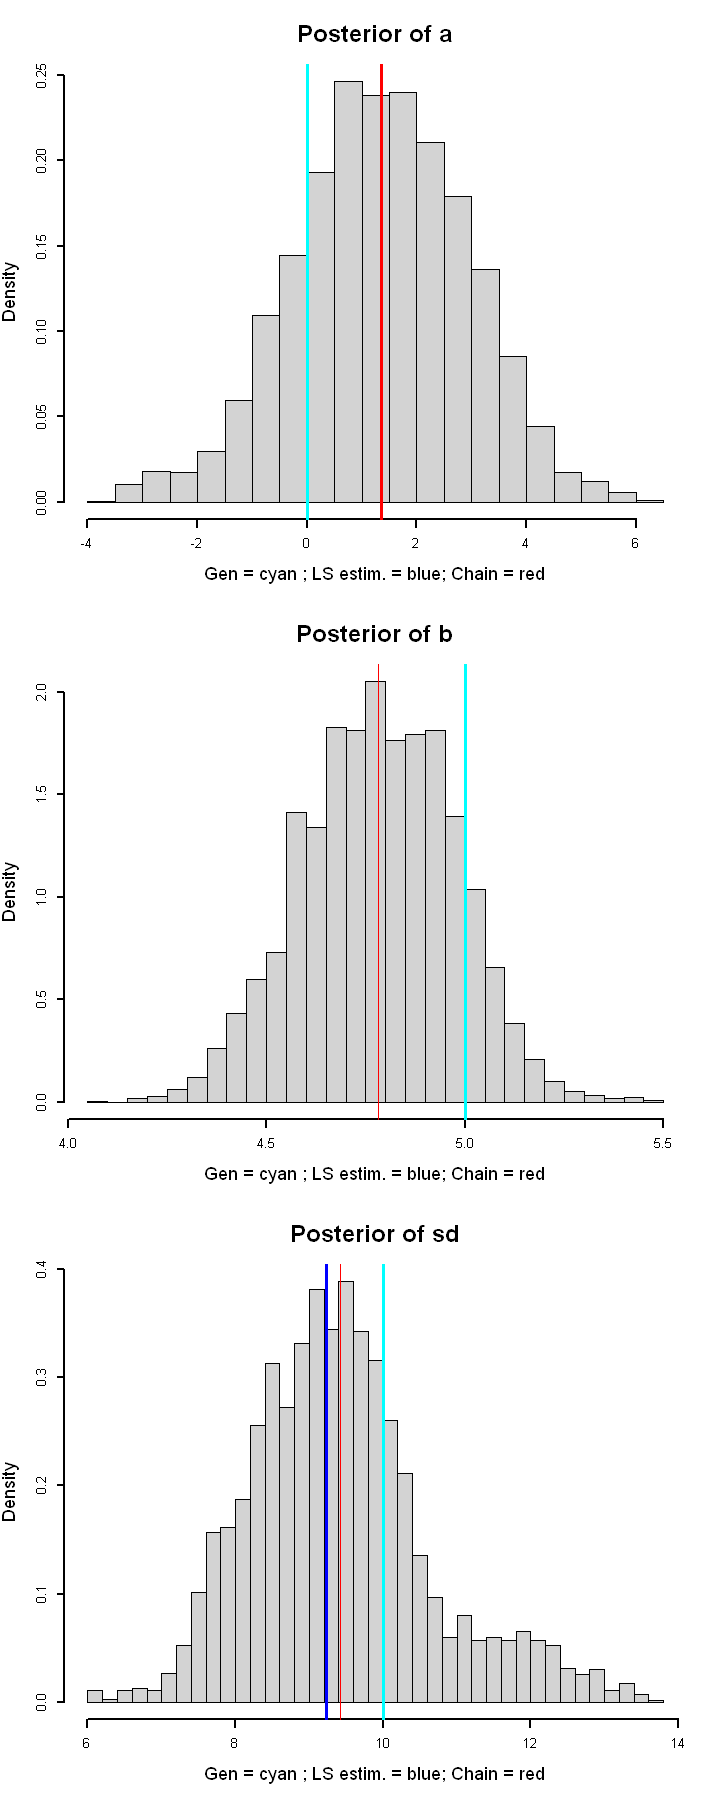

In [13]:
options(repr.plot.width=6,repr.plot.height=15)
old.par<-par(mfrow = c(3,1))
hist(chain[-(1:burnIn),1],nclass=35,freq=FALSE,lwd=2,main="Posterior of a", 
     xlab="Gen = cyan ; LS estim. = blue; Chain = red",cex.main=1.8,cex.lab=1.4)
abline(v = mean(chain[-(1:burnIn),1]),lwd=2.5,col="red")
abline(v = trueA,lwd=2.5, col="cyan")
#abline(v=a.hat,lwd=2.5,col="blue")
hist(chain[-(1:burnIn),2],nclass=35,freq=FALSE,lwd=2,main="Posterior of b",
     xlab="Gen = cyan ; LS estim. = blue; Chain = red",cex.main=1.8,cex.lab=1.4)
abline(v = mean(chain[-(1:burnIn),2]),col="red")
abline(v = trueB,lwd=2.5, col="cyan")
#abline(v=b.hat,lwd=2.5,col="blue")
hist(chain[-(1:burnIn),3],nclass=35,freq=FALSE,lwd=2,main="Posterior of sd", 
     xlab="Gen = cyan ; LS estim. = blue; Chain = red",cex.main=1.8,cex.lab=1.4)
abline(v = mean(chain[-(1:burnIn),3]),col="red")
abline(v = trueSd,lwd=2.5, col="cyan" )
abline(v = sigma.hat,lwd=2.5, col="blue")
par(old.par)

## Traceplot

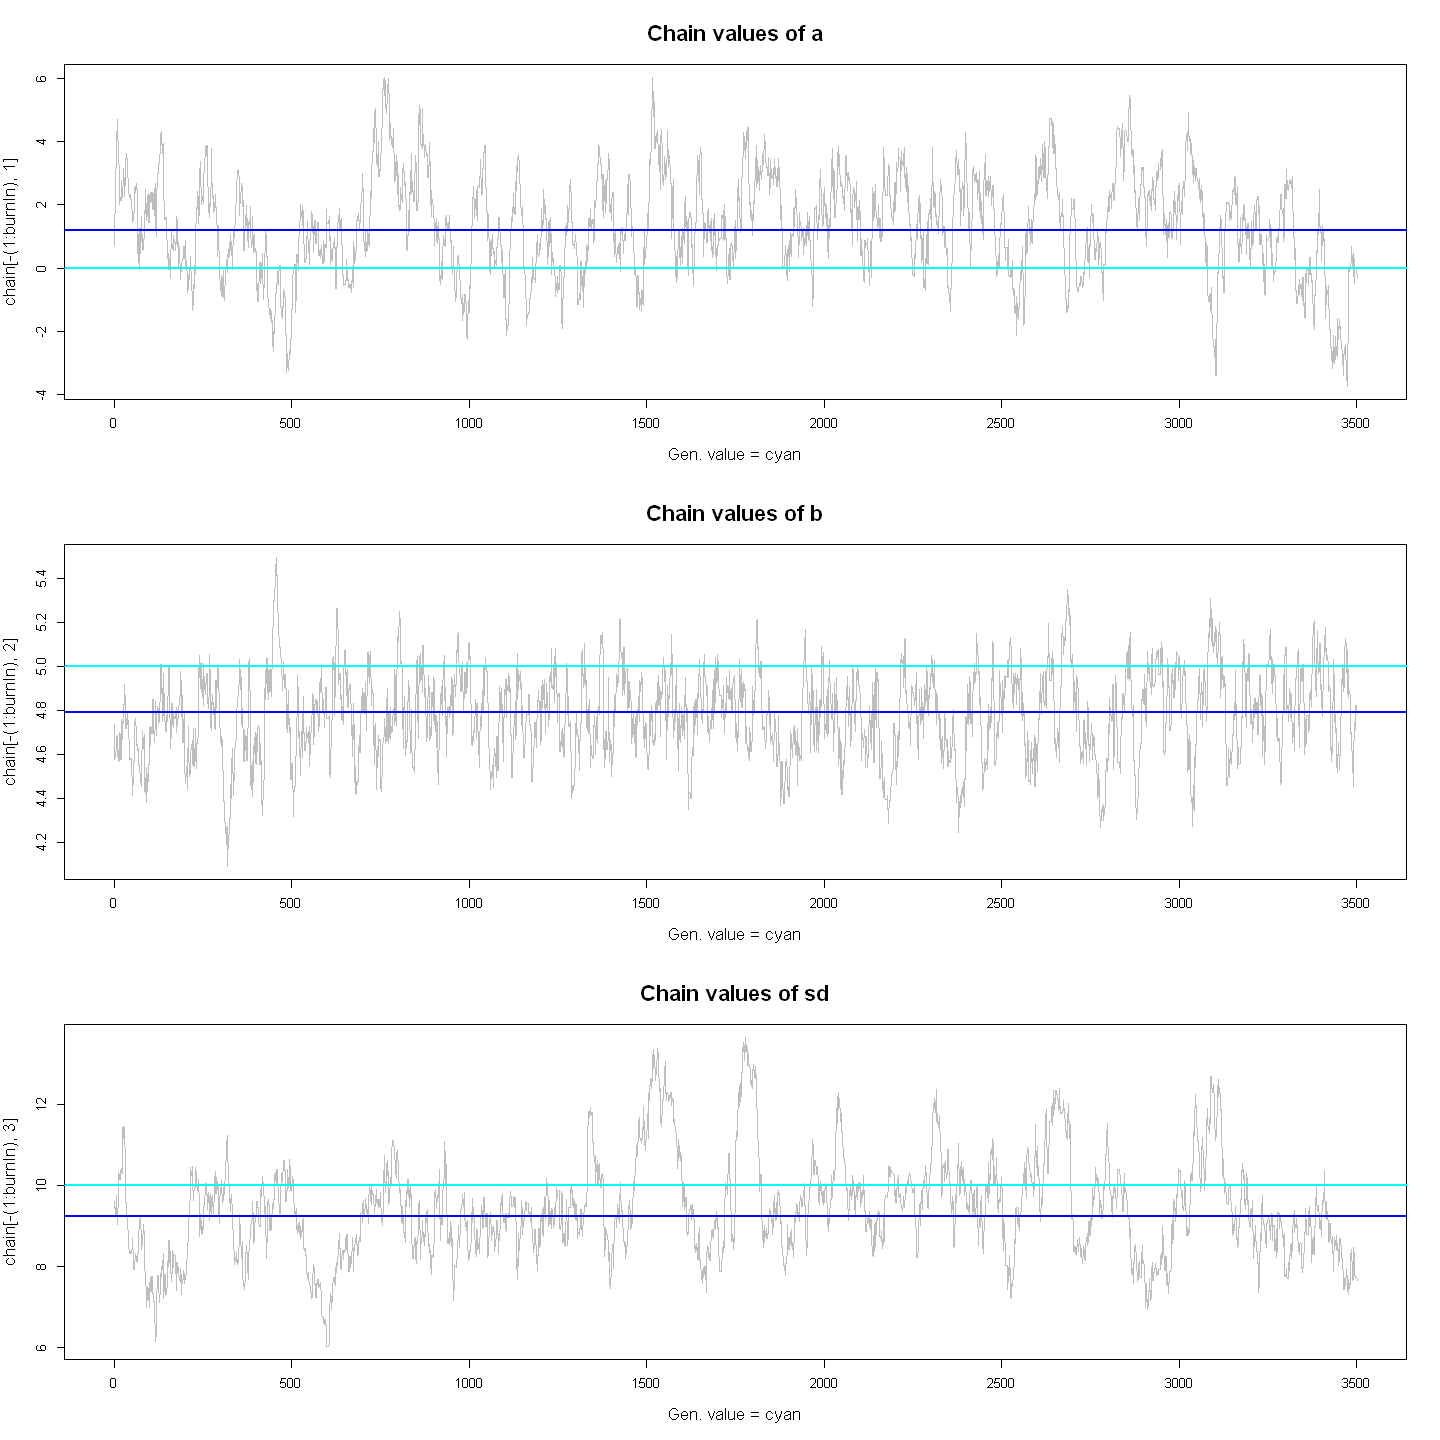

In [14]:
options(repr.plot.width=12,repr.plot.height=12)
old.par<-par(mfrow = c(3,1))
plot(chain[-(1:burnIn),1], type = "l",lwd=0.5,col="gray",
     xlab="Gen. value = cyan", main = "Chain values of a",cex.main=1.7,cex.lab=1.3)
abline(h=trueA,lwd=2.0,col="cyan")
abline(h=a.hat,lwd=2.0,col="blue")
plot(chain[-(1:burnIn),2], type = "l",lwd=0.5,col="gray",
     xlab="Gen. value = cyan", main = "Chain values of b",cex.main=1.7,cex.lab=1.3)
abline(h=trueB,lwd=2.0,col="cyan")
abline(h=b.hat,lwd=2.0,col="blue")
plot(chain[-(1:burnIn),3], type = "l",lwd=0.5,col="gray",
     xlab="Gen. value = cyan", main = "Chain values of sd",cex.main=1.7,cex.lab=1.3)
abline(h=trueSd,lwd=2.0,col="cyan")
abline(h=sigma.hat,lwd=2.0,col="blue")
par(old.par) 

<h1 style="color:blue"> Convergence diagnostics </h1>

## Run simulation to obtain three chains

- Decide chain length and `burnIn`

- Run simulation and discard first `burnIn` values

- Compute the acceptance rate

In [15]:
ChainLength<-4000
set.seed(24025)
startvalue1<-c(-1,5,1)
startvalue2<-c(0,4,10)
startvalue3<-c(2,3,20)
chain1<-metropolis_MCMC(startvalue1,ChainLength)
chain2<-metropolis_MCMC(startvalue2,ChainLength)
chain3<-metropolis_MCMC(startvalue3,ChainLength)
# 
burnIn<-500
# Proportion of accepted transitions = non-duplicated chain values
acceptance1<-1-mean(duplicated(chain1[-(1:burnIn),])) 
acceptance2<-1-mean(duplicated(chain2[-(1:burnIn),])) 
acceptance3<-1-mean(duplicated(chain3[-(1:burnIn),])) 
round(c(acceptance1,acceptance2,acceptance3),3)

[1] 0.780 0.773 0.746

In [16]:
colnames(chain1)<-c("a","b","sigma")
colnames(chain2)<-c("a","b","sigma")
colnames(chain3)<-c("a","b","sigma")

In [18]:
#install.packages("coda", repos= "https://cloud.r-project.org")
require(coda,quietly=TRUE)

In [19]:
chain1.mcmc<-as.mcmc(chain1)
chain2.mcmc<-as.mcmc(chain2)
chain3.mcmc<-as.mcmc(chain3)

In [20]:
simple.regression.m0.mcmc<-as.mcmc.list(list(chain1.mcmc,chain2.mcmc,chain3.mcmc))
str(simple.regression.m0.mcmc)

List of 3
 $ : 'mcmc' num [1:4001, 1:3] -1 -1.209 -0.961 -1.01 -1.205 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:3] "a" "b" "sigma"
  ..- attr(*, "mcpar")= num [1:3] 1 4001 1
 $ : 'mcmc' num [1:4001, 1:3] 0 0.37168 0.8662 0.33871 0.00886 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:3] "a" "b" "sigma"
  ..- attr(*, "mcpar")= num [1:3] 1 4001 1
 $ : 'mcmc' num [1:4001, 1:3] 2 2.14 2.4 2.4 2.26 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:3] "a" "b" "sigma"
  ..- attr(*, "mcpar")= num [1:3] 1 4001 1
 - attr(*, "class")= chr "mcmc.list"


In [21]:
summary(simple.regression.m0.mcmc)


Iterations = 1:4001
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 4001 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean    SD Naive SE Time-series SE
a     1.092 1.712  0.01563         0.1299
b     4.794 0.217  0.00198         0.0114
sigma 9.730 1.631  0.01489         0.1800

2. Quantiles for each variable:

        2.5%      25%   50%    75%  97.5%
a     -2.139 -0.06753 1.021  2.192  4.620
b      4.387  4.66052 4.796  4.934  5.189
sigma  7.369  8.65764 9.570 10.612 12.642


## 1. Gelman and Rubin's convergence diagnostic

Gelman and Rubin's (1992) approach to monitoring convergence is based on detecting when
the Markov chains have forgotten their starting points, by comparing several sequences drawn
from different starting points and checking that they are indistinguishable. 
There are many ways to compare parallel sequences, the most obvious approach being to look 
at overlaid traceplots and see if the two sequences can be distinguished.

A more quantitative approach to answer the question:

<p style="color:#8B0000"> Are the sequences much farther apart than we could expect, based on their internal variability? </p>


Based on the analysis of variance:

Approximate convergence is diagnosed when the variance **between** the different sequences is no larger than the **variance** within each individual sequence. 

Assume we have $m$ parallel simulations, each of length $n$, of the variable $X$. 

The values are denoted by $x_{ij}$, $i= 1,\dots,m$, $j=1,\dots,n$. 

Define:

$$
    \begin{array}{lcl}
    \bar{x}_{i\cdot}    &=&\dfrac{1}{n}\displaystyle\sum_{j=1}^{n}x_{ij}\mskip86mu
    \text{the average of the $i$-th sequence, and}\\[0.45cm]
    \bar{x}_{\cdot\cdot}&=&\dfrac{1}{m\, n}\,\displaystyle\sum_{i=1}^{m}\sum_{j=1}^{n}x_{ij}\mskip50mu
    \text{the overall average.}
    \end{array}
$$

The _between-sequence variance_ $B$ and the _within-sequence variance_ $W$ are:

$$
\begin{array}{lcl}
    B &=&\dfrac{n}{m-1}\,\displaystyle\sum_{i=1}^{m}(\bar{x}_{i\cdot}-\bar{x}_{\cdot\cdot})^{2}\\[0.50cm]
    W &=&\dfrac{1}{m}\,\displaystyle\sum_{i=1}^{m}s_{i}^{2}\mskip80mu\text{where }\mskip30mu
        s_{i}^{2}=\dfrac{1}{n-1}\displaystyle\sum_{j=1}^{n}(x_{ij}-\bar{x}_{i\cdot})^{2}.
\end{array}
$$

From the two variance components, two estimates of the variance of $X$ in the target 
distribution are constructed: First

$$
    \widehat{\var}_{(1)}(X)=\frac{n-1}{n}\, W + \frac{1}{n}\, B
$$

is an estimate of the variance that is unbiased under stationarity (that is, if the starting points of the simulations were actually drawn form the target distribution), 
but is an _overestimate_ under the more realistic assumption that the starting points are overdispersed.

For any finite $n$, the within-sequence variance

$$
    \widehat{\var}_{(2)}(X)=W
$$

should _underestimate_ the variance of $X$ because the individual sequences have had no time
to range over all of the target distribution and, will have less variability. 

In the limit, as $n\to\infty$, both $\widehat{\var}_{(1)}(X)$ and $\widehat{\var}_{(2)}(X)$ approach  $\var(X)$, but from opposite directions.

One can now monitor the convergence of the MC by estimating the factor by which the conservative estimate of the distribution of $X$ might be reduced: that is, 
the ratio between the estimated upper and lower bounds for the standard deviation of $X$, which is called _estimated potential scale reduction_ or _shrink factor:_
    
$$
    \sqrt{\hat{R}}=\sqrt{\frac{\widehat{\var}_{(1)}(X)}{\widehat{\var}_{(2)}(X)}}.
$$

As the simulation converges, the shrink factor declines to $1$, meaning that the parallel Markov chains are essentially overlapping. 

Values substantially above $1$ indicate lack of convergence. 

When the chains have not converged, Bayesian credible intervals based on the $t$-distribution are too wide, and have the potential to shrink by this factor if the MCMC run is continued.

#### If the shrink factor is high, one should add further simulations.

The Gelman and Rubin diagnostics calculated by CODA are the $50\%$ and $97.5\%$ quantiles of the sampling distribution for the shrink factor. 

These quantiles are estimated from the second half of each chain only. 

You can also produce plots to illustrate these diagnostics, i.e. overlaid traceplots and shrink factor plots.

There is a multivariate version of the potential scale reduction factor (psrf), by Brooks, SP and Gelman, A (1998).

### References

Gelman, A and Rubin, DB (1992), _Inference from iterative simulation using multiple sequences,_ Statistical Science, 7, 457-511.

Brooks, SP and Gelman, A (1998), _General methods for monitoring convergence of iterative simulations._ Journal of Computational and Graphical Statistics, 7, 434-455.

In [22]:
gelman.diag(simple.regression.m0.mcmc)

Potential scale reduction factors:

      Point est. Upper C.I.
a           1.03       1.04
b           1.01       1.02
sigma       1.03       1.09

Multivariate psrf

1.03

## 2. Gelman-Rubin-Brooks plot

This plot shows the evolution of Gelman and Rubin's shrink factor as the number of iterations increases.

The Markov chain is divided into bins according to the arguments `bin.width` and `max.bins`. 

Then the Gelman-Rubin shrink factor is repeatedly calculated.   
The first shrink factor is calculated with observations `1:50`,    
the second with observations `1:(50+bin.width)`, the third contains samples `1:(50+2∗bin.width)` and so on. 

If the chain has less than `50+bin.width` iterations then `gelman.diag()` will exit with an error.

A potential problem with `gelman.diag()` is that it may mis-diagnose convergence if the shrink factor happens to be close to 1 by chance.    
By calculating the shrink factor at several points in time, `gelman.plot()` shows if the shrink factor has really converged, or whether it is still fluctuating.

#### References

Brooks, S P. and Gelman, A. (1998) _"General Methods for Monitoring Convergence of Iterative Simulations"._   
Journal of Computational and Graphical Statistics, 7, 434-455.

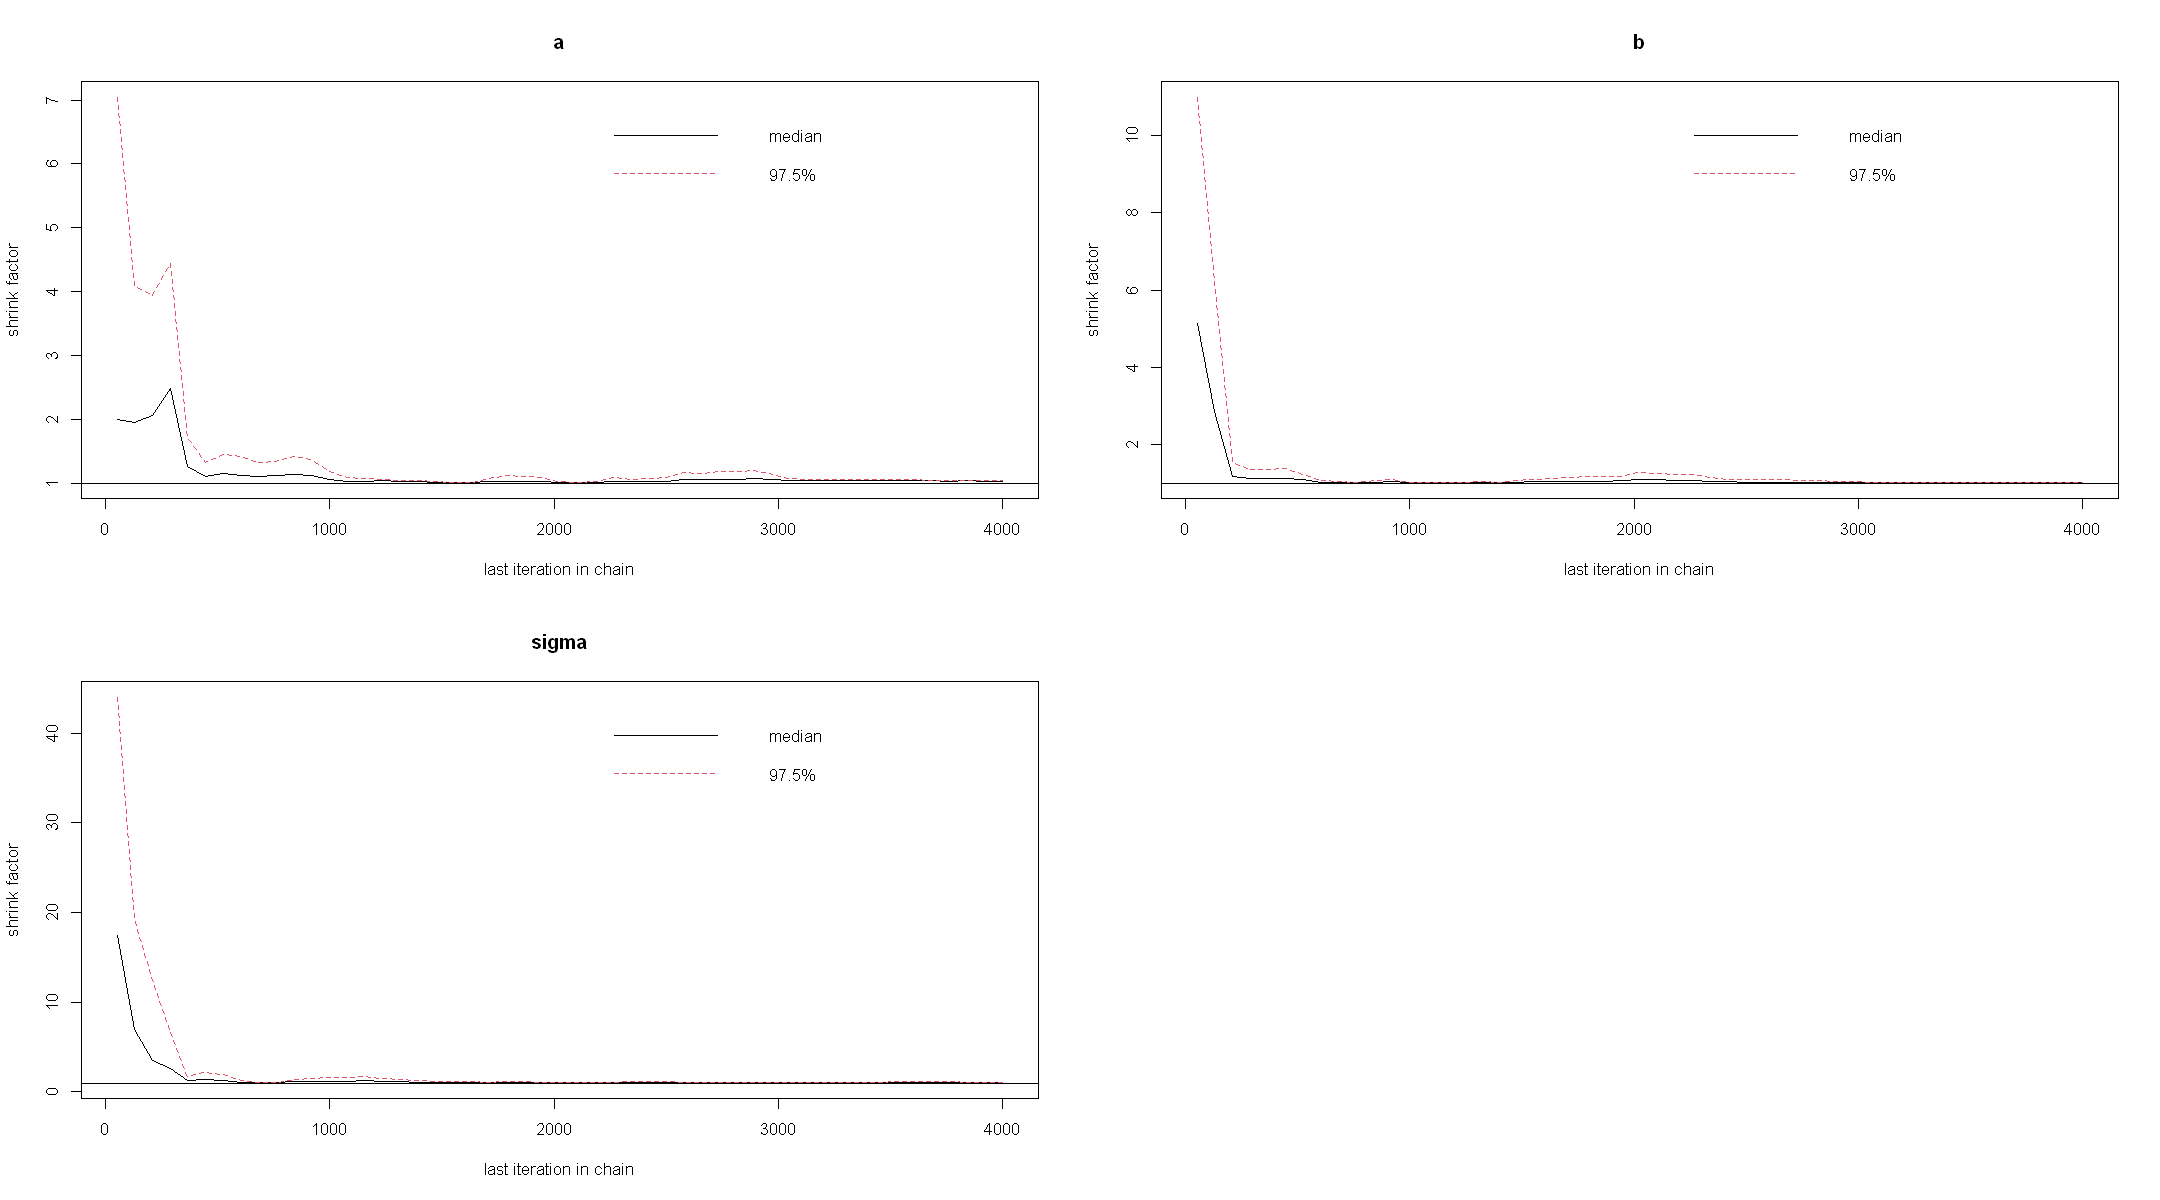

In [23]:
options(repr.plot.width=18,repr.plot.height=10)
gelman.plot(simple.regression.m0.mcmc)

## 3. Geweke's convergence diagnostic

Geweke (1992) proposes a convergence diagnostic based on standard time-series methods.   

It is based on a single chain and is appropriate when convergence of the mean (of some function) of the sampled variable is of interest. 
 
The chain is divided into 2 "windows" containing the first 10% and the last 50% of the iterates. 

If the whole chain is stationary, the means of the values early and late in the sequence should be similar. 

The convergence diagnostic statistic $Z$ is the difference between the two means divided by the asymptotic standard error of their difference. 

The standard error is estimated from the spectral density at zero and so takes into account any autocorrelation

As $n\to\infty$, the sampling distribution of $Z$ goes to $\operatorname{N}(0,1)$ if the chain has converged. 

Hence values of $Z$ which fall in the extreme tails of $\operatorname{N}(0,1)$ indicate that the chain has not yet converged. 

CODA also gives you the option to plot the $Z$-scores.

### References

Geweke J (1992), _Evaluating the accuracy of sampling-based approaches to calculating posterior moments._   
In: Bernardo JM, Berger JO , Dawid AP and Smith AFM  (eds.). _Bayesian Statistics 4,_ Clarendon Press, Oxford, UK.

In [24]:
geweke.diag(simple.regression.m0.mcmc)

[[1]]

Fraction in 1st window = 0.1
Fraction in 2nd window = 0.5 

      a       b   sigma 
 0.7315  0.7476 -2.7358 


[[2]]

Fraction in 1st window = 0.1
Fraction in 2nd window = 0.5 

      a       b   sigma 
-0.1404 -1.4005 -1.4919 


[[3]]

Fraction in 1st window = 0.1
Fraction in 2nd window = 0.5 

       a        b    sigma 
 1.45194 -0.06412  0.79562 



The resulting $Z$ scores should be compared to the quantiles $0.025$ and $0.975$ of a $\normaldist(0,1)$. around $\pm2$

In [25]:
qnorm(0.025)
qnorm(0.975)

[1] -1.959964

[1] 1.959964

## 4. Geweke-Brooks plot

If `geweke.diag` indicates that the first and last part of a sample from a Markov chain are not drawn from the same distribution,   
it may be useful to discard the first few iterations to see if the rest of the chain has "converged". 

This plot shows what happens to Geweke's $Z$-score when successively larger numbers of iterations are discarded from the beginning of the chain. 

To preserve the asymptotic conditions required for Geweke's diagnostic, the plot never discards more than half the chain.

The first half of the Markov chain is divided into `nbins - 1` segments, then Geweke's $Z$-score is repeatedly calculated. 

The first $Z$-score is calculated with all iterations in the chain,   
the second after discarding the first segment,   
the third after discarding the first two segments, and so on. 

The last $Z$-score is calculated using only the samples in the second half of the chain.

#### Note

The graphical implementation of Geweke's diagnostic was suggested by Steve Brooks.

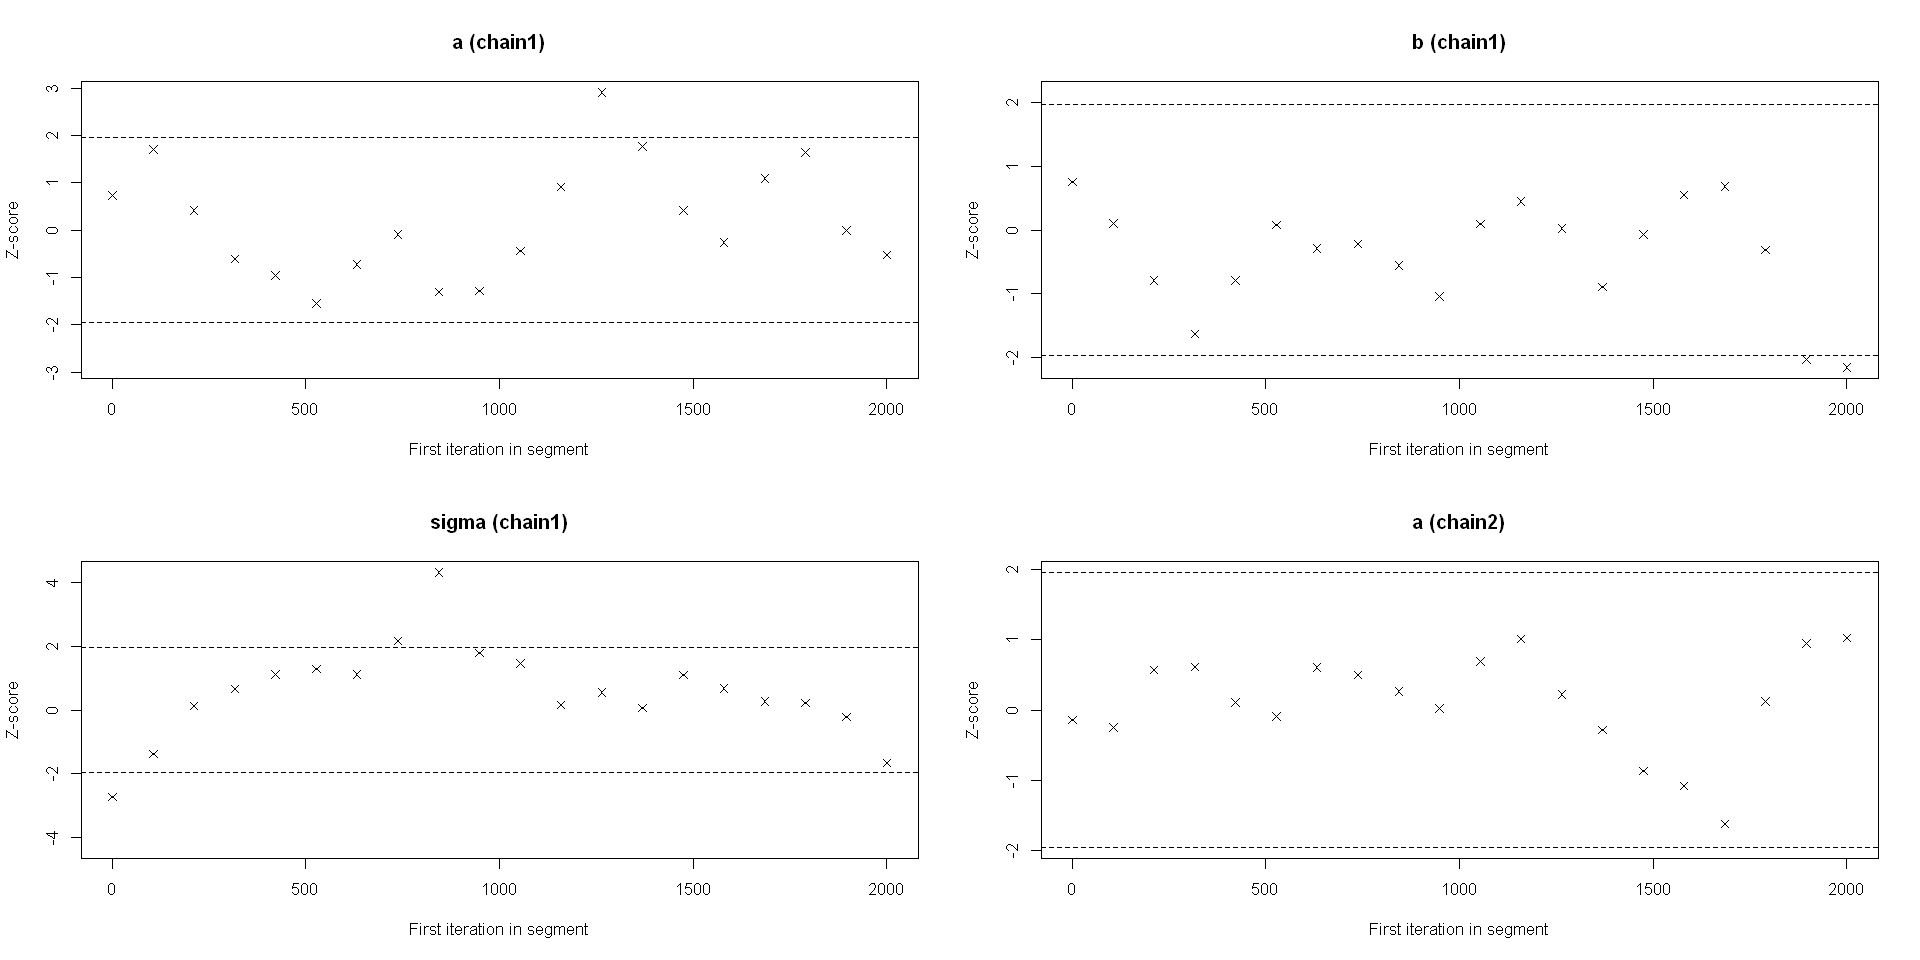

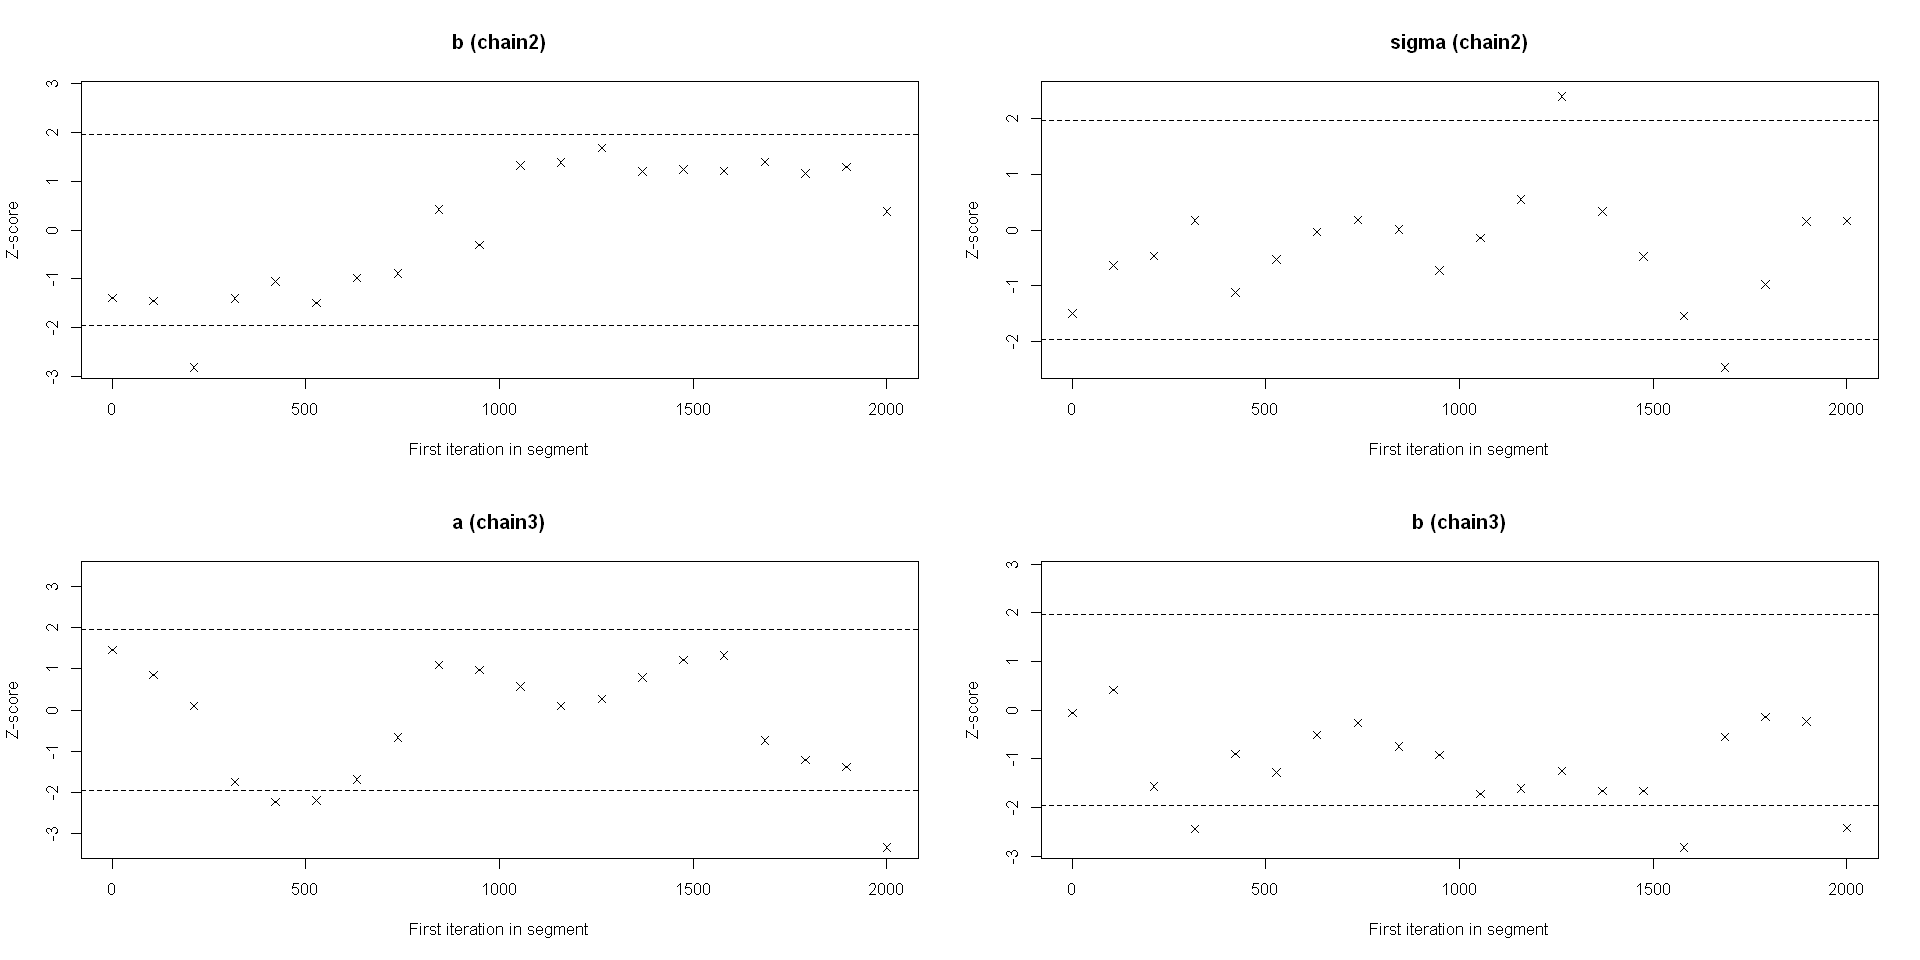

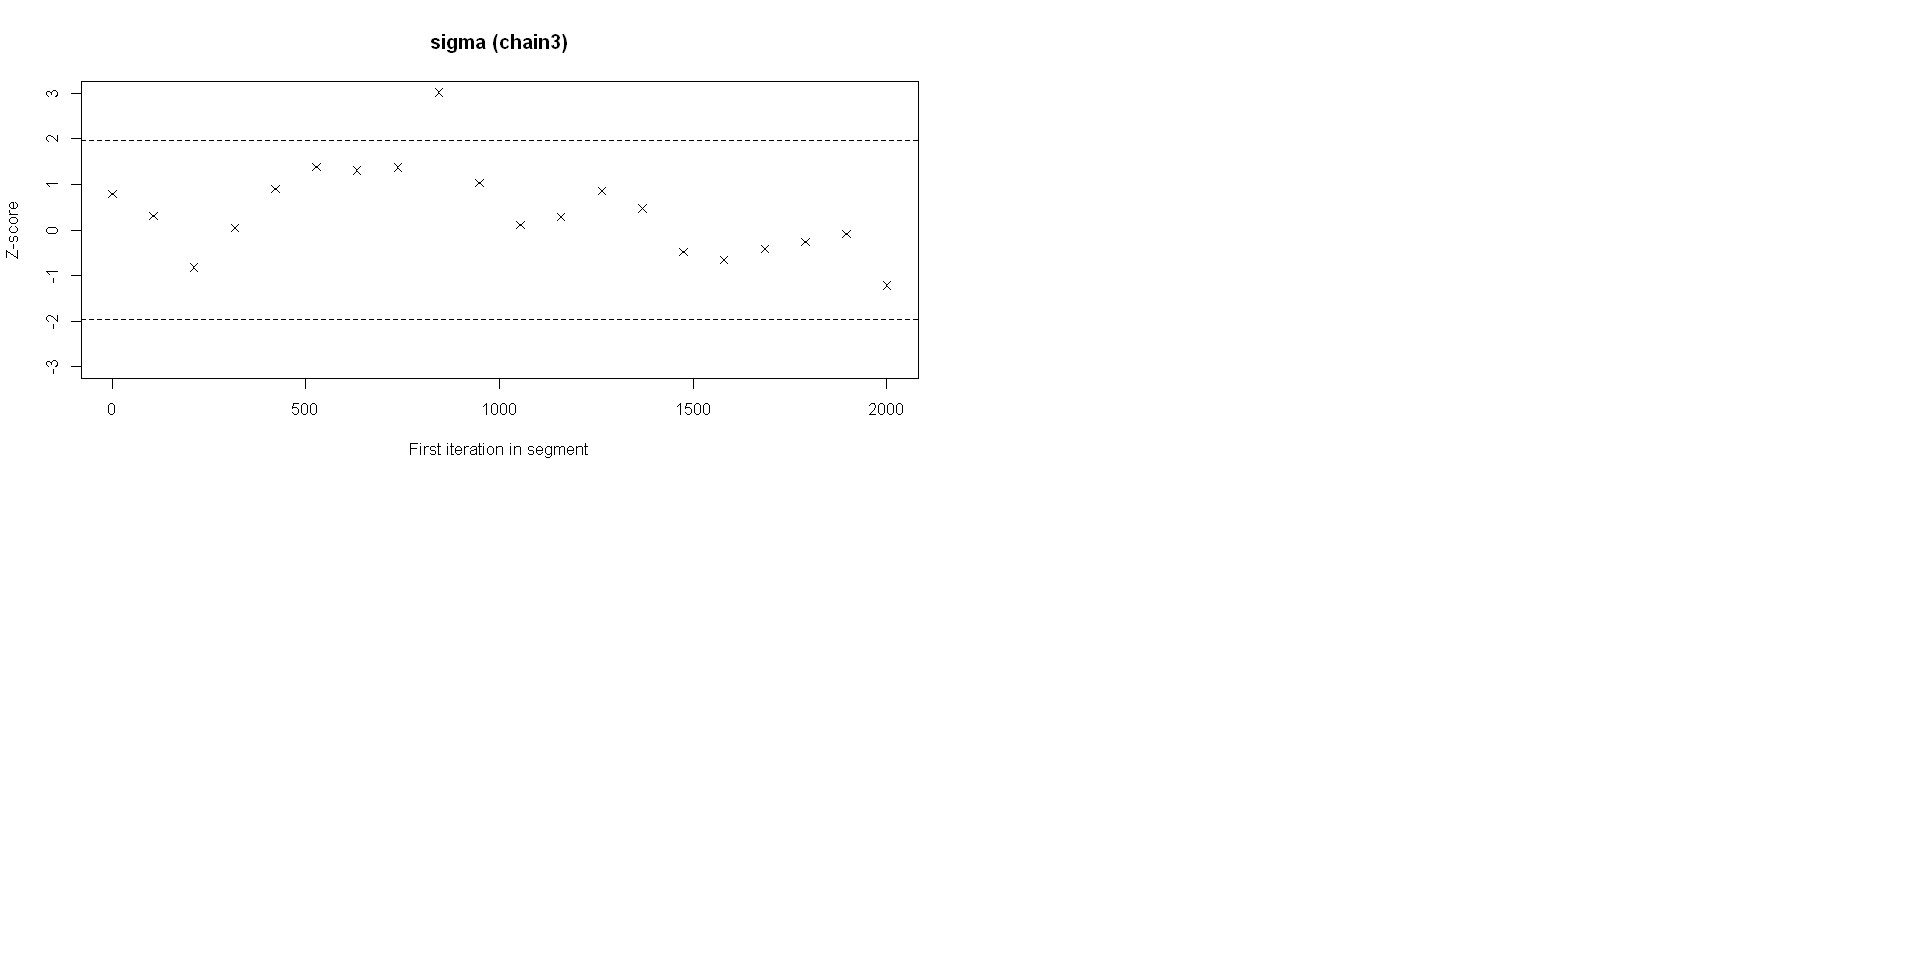

In [26]:
options(repr.plot.width=16,repr.plot.height=8)
geweke.plot(simple.regression.m0.mcmc)

## 5. Heidelberger and Welch's convergence diagnostic

Heidelberger and Welch's (1983) method basically uses the Cramer-von-Mises statistic to test the null hypothesis that the sampled values for each variable form a stationary process.

If the null hypothesis is rejected for a given variable, the test is repeated after discarding the first 10% of iterations. 

If the hypothesis is again rejected, a further 10% of iterations are discarded. 

This process is repeated until either a portion of the chain passes the test, or 50% of the iterations have been discarded and $H_{0}$ is still rejected. 

In the latter case, CODA reports the Cramer-von-Mises statistic and indicates that the stationarity test was failed.

If the stationarity test is passed, CODA reports the number of iterations to keep, the number of initial iterations to discard and the Cramer-von Mises statistic. 

A halfwidth test is then carried out as follows: for each variable the portion of the data which passed the stationarity test is used to estimate the asymptotic standard error of the mean via a time-series method. 

CODA reports the sample mean of the retained iterates and the halfwidth of the associated 95% confidence interval for this mean. 

If the halfwidth is less than a given $\epsilon$ (default is 0.1) times the sample mean, the halfwidth test is passed and the retained sample is deemed to estimate the posterior mean with acceptable precision. If the halfwidth test is failed, this implies a longer run is needed.

### References

Heidelberger P, and Welch PD (1981), _A spectral method for confidence interval generation and run length control in simulations,_ Communications of the ACM 24, 233-245.

Heidelberger P, and Welch PD (1983), _Simulation run length control in the presence of an initial transient,_ Operations Research 31, 1109-1144.

Schruben LW (1982), _Detecting initialization bias in simulation experiments,_ Operations Research 30, 569-590.

In [27]:
heidel.diag(simple.regression.m0.mcmc)

[[1]]
                                    
      Stationarity start     p-value
      test         iteration        
a     passed       1         0.843  
b     passed       1         0.774  
sigma passed       1         0.653  
                              
      Halfwidth Mean Halfwidth
      test                    
a     failed    1.25 0.3654   
b     passed    4.80 0.0296   
sigma passed    9.56 0.4636   

[[2]]
                                    
      Stationarity start     p-value
      test         iteration        
a     passed       1         0.996  
b     passed       1         0.156  
sigma passed       1         0.558  
                              
      Halfwidth Mean Halfwidth
      test                    
a     failed    1.00 0.5137   
b     passed    4.80 0.0307   
sigma passed    9.68 0.3571   

[[3]]
                                    
      Stationarity start     p-value
      test         iteration        
a     passed         1       0.9566 
b     passed    

## 6. Raftery and Lewis's diagnostic

Raftery and Lewis (1992) developed a method that can be used to determine the number of burn-in iterations to discard and the thinning, i.e. the number $k$ for storing every $k$-th iteration. 

This will reduce the amount of storage, especially when consecutive iterations are highly correlated, necessitating a long run.

You must specify the quantile to be estimated (default is 2.5%), the desired degree of accuracy for the estimate of this quantile (default $=\pm0.005$), and the required probability of attaining this degree of accuracy (default is 0.95). 

CODA then reports

- `Nmin`, the minimum number of iterations that would be needed to estimate the specified quantile to the desired precision if the samples were independent. This is a theoretical value based on the binomial variance and provides a lower bound for the run-length of the Gibbs sampler. `Nmin` will increase as the required probability and degree of accuracy increase.
- `N`, the total number of iterations that should be run for each variable.
- `M`, the number of initial iterations to discard as the burn-in.
- `k`, the thinning interval to be used.
- `I = N/Nmin`, which measures the increase in number of iterations needed to reach convergence due to dependence between the samples in the chain.   
Values of `I` much greater than 1 (`I` > 5) indicate high within-chain correlations and likely convergence failure and reparametrization is advised. 

### References

Raftery, AE, and Lewis SM (1992), _One long run with diagnostics: Implementation strategies for Markov chain Monte Carlo,_ Statistical Science 7, 493-497.

Raftery, AE, and Lewis SM (1995), _The number of iterations, convergence diagnostics and generic Metropolis algorithms,_      
In: Gilks WR, Spiegelhalter DJ, and Richardson  S (eds.), _Practical Markov Chain Monte Carlo_ London, UK: Chapman and Hall.

In [28]:
raftery.diag(simple.regression.m0.mcmc)

[[1]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
       Burn-in  Total Lower bound  Dependence
       (M)      (N)   (Nmin)       factor (I)
 a     27       29213 3746          7.80     
 b     21       23313 3746          6.22     
 sigma 54       56160 3746         15.00     


[[2]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
       Burn-in  Total Lower bound  Dependence
       (M)      (N)   (Nmin)       factor (I)
 a     39       42799 3746         11.40     
 b     20       22730 3746          6.07     
 sigma 40       42850 3746         11.40     


[[3]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                             
       Burn-in  Total Lower bound  Dependence
       (M)      (N)   (Nmin)       factor (I)
 a     72       83046 3746         22.20     
 b     49       49729 3746   